# Functional analysis: progeny / dorothea

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import atlas_protocol_scripts as aps
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import decoupler as dc
import itertools
from pathlib import Path
import numpy as np
from scipy import sparse
import seaborn as sns
import urllib.request

from threadpoolctl import threadpool_limits
import multiprocessing

import os

# set PATH env variable to conda env for altair_saver which is looking for npm
os.environ["PATH"] = os.path.dirname(os.environ["_"]) + os.pathsep + os.environ["PATH"]

cpus = 16
os.environ["NUMBA_NUM_THREADS"] = str(cpus)
threadpool_limits(cpus)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Configure paths

In [3]:
adata_path = "../../data/input_data_zenodo/atlas-integrated-annotated.h5ad"
results_dir = "../../results/10_functional_analysis"

tfnet_file = Path(results_dir, "tf_net_dorothea_hs.tsv")
pwnet_file = Path(results_dir, "pw_net_progeny_hs.tsv")



Create results directory

In [4]:
os.makedirs(results_dir, mode = 0o750, exist_ok = True)

## Load data

In [5]:
adata = sc.read_h5ad(adata_path)

In [6]:
if Path(tfnet_file).exists():
    tfnet = pd.read_csv(tfnet_file, sep="\t")
else:
    tfnet = dc.get_dorothea(organism='human', levels=['A','B','C'])
    tfnet.to_csv(tfnet_file, sep="\t", index=False)

In [7]:
if Path(pwnet_file).exists():
    pwnet = pd.read_csv(pwnet_file, sep="\t")
else:
    pwnet = dc.get_progeny(organism='human', top=100)
    pwnet.to_csv(pwnet_file, sep="\t", index=False)

In [8]:
adata

AnnData object with n_obs × n_vars = 62119 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'cell_type', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'cell_type_major', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_cell_type_tumor_predicted_colors', '_scvi', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_major_colors', 'cell_type_predicted_colors', 'cell_type_tumor_colors', 'condition_colors', 'dataset_colors', 'doublet_status_colors', 'eve

In [9]:
adata.obs["condition"].unique()

['LUSC', 'NSCLC NOS', 'LUAD']
Categories (3, object): ['LUAD', 'LUSC', 'NSCLC NOS']

In [10]:
adata.obs["cell_type_coarse"].unique()

['B cell', 'T cell', 'Epithelial cell', 'Macrophage/Monocyte', 'Mast cell', ..., 'Stromal', 'NK cell', 'Endothelial cell', 'pDC', 'Neutrophils']
Length: 12
Categories (12, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Macrophage/Monocyte', ..., 'Stromal', 'T cell', 'cDC', 'pDC']

## Define contrasts

In [11]:
contrasts = [
    dict(name = "LUSC_vs_LUAD", condition = "LUSC", reference = "LUAD"),
]
contrasts

[{'name': 'LUSC_vs_LUAD', 'condition': 'LUSC', 'reference': 'LUAD'}]

### create result directories for each contrast

In [12]:
for contrast in contrasts:
    res_dir = Path(results_dir, contrast["name"])
    os.makedirs(res_dir, mode = 0o750, exist_ok = True)
    contrast["res_dir"] = res_dir

### Create pseudobulk for each celltype using the coarse cell type annotation

In [13]:
# Store raw rounded counts in layers
# adata.layers['int_counts'] = adata.layers['raw_counts']
adata.layers['int_counts'] = sparse.csr_matrix.ceil(adata.layers['raw_counts'])

In [14]:
pdata = dc.get_pseudobulk(adata,
                          sample_col='sample',
                          groups_col='cell_type_coarse',
                          layer='int_counts',
                          mode='sum',
                          min_cells=10,
                          min_counts=1000
                         )
pdata

AnnData object with n_obs × n_vars = 385 × 17837
    obs: 'sample', 'uicc_stage', 'sex', 'ever_smoker', 'driver_genes', 'condition', 'age', 'patient', 'tissue', 'origin', 'dataset', 'doublet_status', 'total_counts_mito', 'pct_counts_mito', 'cell_type_coarse', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'platform_fine', 'batch', '_predictions', '_leiden', '_cell_type_tumor_predicted', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [17]:
pdata.obs["condition"].unique()

array(['LUSC', 'NSCLC NOS', 'LUAD'], dtype=object)

In [ ]:
cell_types = pdata.obs["cell_type_coarse"].unique()

In [117]:
%%capture

# Run deseq2 on pseudobulk all cell types
de_res = {}

for ct in cell_types:
    print("Working on: " + ct)
    pb_ct = pdata[pdata.obs['cell_type_coarse'] == ct].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=pb_ct,
        design_factors='condition',
        refit_cooks=True,
        n_cpus=8,
    )

    # Compute LFCs
    dds.deseq2();

    # Extract contrast between LUAD vs LUSC
    stat_res = DeseqStats(dds, contrast=["condition", "LUSC", "LUAD"], n_cpus=cpus);

    # Compute Wald test
    stat_res.summary();

    # Shrink LFCs
    stat_res.lfc_shrink(coeff="condition_LUSC_vs_LUAD");

    # Register cell type results
    de_res[ct] = stat_res.results_df
    

In [118]:
de_res['B cell']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,50.409218,-0.050075,0.315535,0.684423,0.493708,0.999812
A1BG-AS1,22.417454,-0.029608,0.319454,-0.303548,0.761472,0.999812
A2M,9.763308,0.107442,0.342890,1.601343,0.109301,0.999812
A2M-AS1,0.095158,-0.008182,0.442339,0.209321,0.834197,0.999812
A2ML1,0.137764,0.030349,0.437141,0.664652,0.506273,0.999812
...,...,...,...,...,...,...
ZXDC,35.414482,-0.055596,0.333348,-0.791374,0.428726,0.999812
ZYG11A,1.836145,0.152655,0.408677,2.041125,0.041238,0.999812
ZYG11B,41.314243,-0.075667,0.331680,-1.183747,0.236513,0.999812
ZYX,76.633675,0.143717,0.311659,0.935613,0.349472,0.999812


In [114]:
# Concat and build the stat matrix
stat_mat = (
    pd.concat(
            [
                res.loc[:, ["stat"]]
                .rename(columns={"stat": ct})
                for ct, res in de_res.items()
            ],
            axis=1,
            sort=True,
    )
    .fillna(0)
    .T
)
stat_mat

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
B cell,0.684423,-0.303548,1.601343,0.209321,0.664652,0.860196,0.000000,-0.625619,-0.074876,0.515725,...,-0.151043,-0.471421,-0.264298,0.212700,-1.551398,-0.791374,2.041125,-1.183747,0.935613,-0.438276
Endothelial cell,-0.253354,1.143024,-1.871821,-1.301253,0.838570,2.534586,0.000000,-0.732096,2.002085,0.245973,...,1.058090,1.103358,-1.199881,0.083750,1.584533,-1.167762,0.801459,0.589046,0.517857,-2.129528
Epithelial cell,2.419084,0.526893,-2.169668,-0.217421,1.378207,3.885969,0.000000,-1.369695,-1.373027,-1.606962,...,0.147592,0.470640,1.003928,-1.161040,-1.137526,-1.214502,1.048548,-1.085929,-0.683787,-0.586609
Macrophage/Monocyte,1.887552,-1.810083,-1.159946,-1.056890,-0.089742,3.591771,0.647005,-0.251056,-1.113955,0.923745,...,1.158934,0.456436,1.195565,0.350645,0.693872,-1.945580,1.543994,1.193480,-1.669678,-1.845599
Mast cell,1.302298,-0.146558,-2.031083,0.782389,0.429370,1.451368,0.633780,-0.535325,-1.273304,0.000000,...,-0.398781,0.022905,0.105666,-0.805223,0.682189,0.176131,0.857360,-0.218627,0.142690,-1.842969
NK cell,1.725606,-1.121034,-0.458949,0.801175,1.437149,1.971736,0.936706,0.059218,-1.618588,1.008651,...,0.860220,0.914887,0.565151,0.838835,-0.497482,-0.509860,1.162220,0.314234,-0.980920,-0.686463
Neutrophils,-0.150990,-0.159348,0.389395,0.046963,1.456457,2.961603,-0.342699,0.893000,0.289581,0.974607,...,1.439581,0.734540,1.149944,0.461943,1.767515,0.581324,0.467897,0.651379,-1.370016,-0.339875
Plasma cell,2.342408,-0.843355,0.110927,0.351568,1.257102,1.831766,1.315403,-0.439805,-1.039953,1.386719,...,0.558146,0.771859,0.334057,-0.492667,-0.743263,1.087382,0.858017,1.008448,0.995226,1.844273
Stromal,0.137209,-2.405250,-3.248257,-1.364812,0.551220,2.935759,0.909617,-0.946916,-0.540265,1.254717,...,1.032618,0.853582,0.295237,-0.155985,1.581859,0.305391,0.588828,-0.047608,-1.333467,-1.180155
T cell,1.968212,-1.405101,-2.254733,1.026358,3.538895,3.018382,0.469284,-2.452540,-1.928387,1.135368,...,0.001898,-0.104951,0.463285,0.019215,-0.227251,-1.299807,1.341416,-0.725741,-0.043823,-1.022794


In [95]:
# Infer pathway activities with consensus
pathway_acts, pathway_pvals = dc.run_consensus(mat=stat_mat, net=pwnet)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cell,0.062939,-0.910739,-1.038329,-1.624462,0.507894,-0.351957,-0.602665,-0.378580,0.858945,0.321914,0.623660,-1.260204,-0.758539,1.988513
Endothelial cell,0.129955,0.194947,0.630472,-0.382399,-1.737014,0.313977,2.064026,0.598129,-0.733381,0.458351,1.758808,-0.049834,0.192832,0.439736
Epithelial cell,-0.303212,-0.303766,-0.368689,0.526601,-0.380728,-1.082579,-1.459781,-0.261235,-1.110388,-2.071201,1.249942,-0.056985,-0.302893,0.987254
Macrophage/Monocyte,-0.482002,-1.010177,-0.327329,-1.336789,-0.582139,-0.909175,-2.019901,-0.128961,-0.356757,-0.730278,0.271995,-0.331442,1.045610,1.216933
Mast cell,-0.558213,-1.169621,1.020281,-0.310194,-1.397407,-1.258175,-1.358884,-0.892186,-0.138127,-0.991052,0.665459,-0.356392,0.888819,1.105882
NK cell,-0.183768,-0.484799,-0.325389,-1.181857,-2.436950,-0.672178,-0.374020,-0.207960,1.151950,0.274978,0.427968,-0.338431,1.628383,0.340598
Neutrophils,1.027670,-0.708179,-0.369533,1.457522,-2.416576,0.352103,-0.471915,-0.158605,-0.438747,-0.291791,-0.660848,0.303715,0.324001,1.387553
Plasma cell,0.469449,-1.031615,0.627337,-0.701767,-1.576447,-0.047319,-1.074090,0.449529,1.688283,-0.700847,0.954997,-0.392691,1.030743,1.051407
Stromal,-0.354937,-0.243664,0.156538,-1.626976,-0.154900,0.430590,1.072540,-0.268128,-1.403998,-0.527387,1.749872,-1.474300,0.554584,0.759733
T cell,-0.223223,-0.729068,-0.702562,-1.049729,-2.374628,-0.569556,-0.519256,-0.246436,-0.271419,0.419378,0.666087,-0.943721,0.681331,1.493188


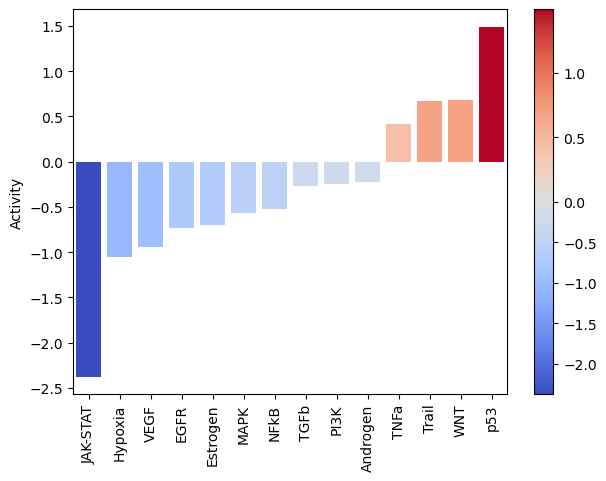

In [96]:
dc.plot_barplot(pathway_acts, 'T cell', top=25, vertical=False)

TypeError: list indices must be integers or slices, not str

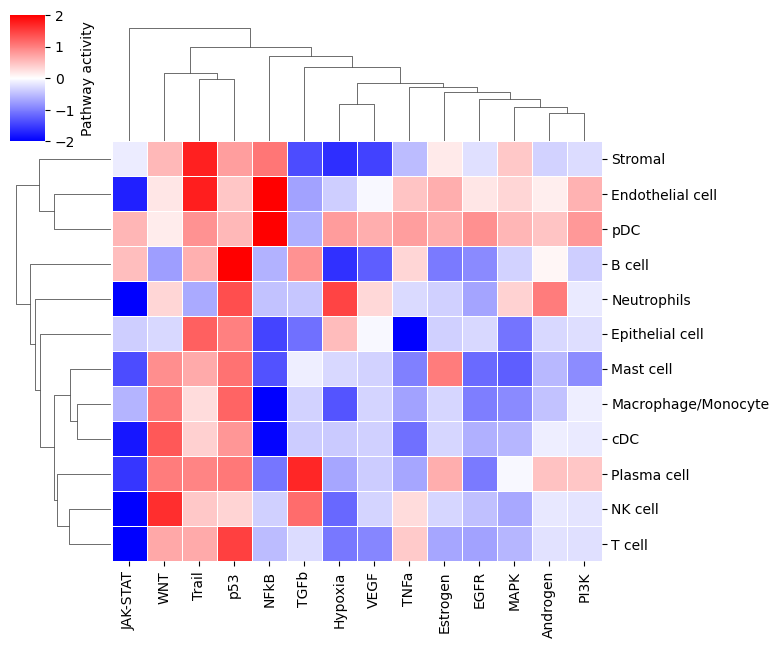

In [99]:
# generate heatmap plot
with plt.rc_context({"figure.figsize": (5.2, 5)}):
    chm = sns.clustermap(
        pathway_acts, 
        center=0, 
        cmap='bwr', 
        linewidth=0.5, 
        cbar_kws={"label": "Pathway activity"},
        vmin=-2,
        vmax=2, 
        figsize=(7,7)
    )
    aps.pl.reshape_clustermap(chm, cell_width=0.05, cell_height=0.05)
    #aps.save_fig_mfmt(chm, res_dir=f"{contrast['res_dir']}/pathways/DC", filename=f"{contrast['name']}_progeny_pw_pb_acts", fmt="all", plot_provider="mpl")
    aps.pl.save_fig_mfmt(chm, res_dir=f"{contrasts['LUSC_vs_LUAD']['res_dir']}/pathways/DC", filename=f"{contrasts['LUSC_vs_LUAD']['name']}_progeny_pw_pb_acts", fmt="all", plot_provider="mpl")
    plt.show()

    
# store acts
#contrast["pathway_acts"] = pathway_acts
#contrast["pathway_pvals"] = pathway_pvals

# save tsv
#tsv_dir = Path(contrast['res_dir'], "pathways", "DC", "tsv")
#os.makedirs(tsv_dir, mode = 0o750, exist_ok = True)

#pathway_acts.to_csv(f"{tsv_dir}/{contrast['name']}_pathway_dc_pb_acts.tsv", sep="\t")
display(pathway_acts)

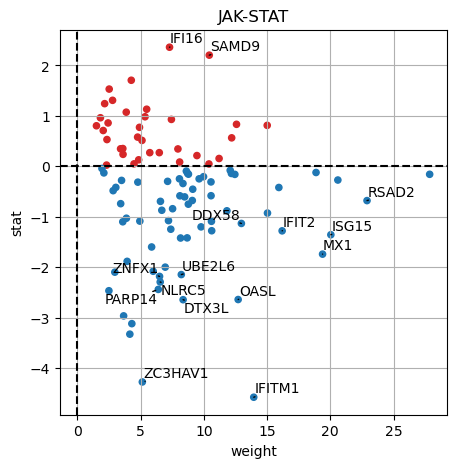

In [115]:
dc.plot_targets(de_res['T cell'], stat='stat', source_name='JAK-STAT', net=pwnet, top=15)